In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.utils.vis_utils import plot_model
import sklearn
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import math
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
#from tensorflow import set_random_seed
from numpy.random import seed
#set_random_seed(1)
seed(1)

train = pd.read_csv('TestData/full_trainset.csv',',')

train.describe()

,Assembly,Material,OpenOrders,NewOrders,TotalWork,TotalSetup,SumDuration,SumOperations,ProductionOrders,CycleTime
count,68552.000000,6.855200e+04,68552.000000,68552.000000,68552.000000,68552.000000,68552.000000,68552.000000,68552.000000,68552.000000
mean,83.834927,7.140528e+08,17.922424,2.417129,5.589963,9.591012,221.157340,21.914167,4.382833,3196.616802
std,21.152932,1.803094e+08,13.365124,1.801401,2.404391,2.295356,87.725997,8.740231,1.748046,1653.565104
min,8.024405,6.544642e+07,2.000000,0.000000,0.000000,0.000000,145.000000,15.000000,3.000000,1460.000000
25%,73.395460,6.259937e+08,10.000000,1.000000,3.880000,8.860000,153.000000,15.000000,3.000000,2053.000000
50%,92.351915,7.821824e+08,13.000000,2.000000,5.240000,10.180000,197.000000,20.000000,4.000000,2660.000000
75%,99.191800,8.479752e+08,19.000000,3.000000,7.440000,11.120000,255.000000,25.000000,5.000000,3778.000000
max,108.421820,9.245294e+08,91.000000,12.000000,11.480000,13.530000,442.000000,45.000000,9.000000,14855.000000


In [2]:
train

,Assembly,Material,OpenOrders,NewOrders,TotalWork,TotalSetup,SumDuration,SumOperations,ProductionOrders,CycleTime
0,16.898176,93773420,6,0,0.66,1.32,158,15,3,2074
1,16.898176,93773420,6,0,0.66,1.32,245,25,5,3027
2,16.898176,93773420,6,0,0.66,1.32,150,15,3,1906
3,16.310417,129137490,8,0,3.16,7.93,201,20,4,2496
4,16.310417,129137490,8,0,3.16,7.93,152,15,3,2000
...,...,...,...,...,...,...,...,...,...,...
68547,105.828920,882328600,12,4,3.28,8.08,151,15,3,1543
68548,105.553474,893276000,14,5,5.45,11.52,156,15,3,1975
68549,105.553474,893276000,14,5,5.45,11.52,255,25,5,3365
68550,106.431946,897071550,15,0,6.40,11.95,158,15,3,1824


In [3]:
split_fraction = 0.70
train_split = int(split_fraction * int(train.shape[0]))
step = 1

#past = 0
#future = 8
learning_rate = 0.0005
batch = 128
epochs = 100
mean = 0
std = 0

def normalize(data, train_split):
    global mean
    global std
    data_mean = data[:train_split].mean(axis=0)
    mean = data_mean
    data_std = data[:train_split].std(axis=0)
    std = data_std
    return (data - data_mean) / data_std

In [4]:
titles = ['Assembly',
          'Material',
#           'OpenOrders',
#           'NewOrders',
          'TotalWork',
          'TotalSetup',
          'SumDuration',
          'SumOperations',
          'ProductionOrders',
          'CycleTime']
#  
# for c in train.columns:
#     titles.append(c);
    
features = train[titles]
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6,7
0,-3.233757,-3.517613,-2.141174,-3.915902,-0.718292,-0.789559,-0.789559,-0.726239
1,-3.233757,-3.517613,-2.141174,-3.915902,0.274358,0.355623,0.355623,-0.196263
2,-3.233757,-3.517613,-2.141174,-3.915902,-0.809571,-0.789559,-0.789559,-0.819666
3,-3.262115,-3.319046,-1.150467,-0.791841,-0.227672,-0.216968,-0.216968,-0.491559
4,-3.262115,-3.319046,-1.150467,-0.791841,-0.786751,-0.789559,-0.789559,-0.767391


In [5]:
train_data = features.loc[0 : train_split - 1] #Training Data
val_data = features.loc[train_split:] #Validation Data
train_data

,0,1,2,3,4,5,6,7
0,-3.233757,-3.517613,-2.141174,-3.915902,-0.718292,-0.789559,-0.789559,-0.726239
1,-3.233757,-3.517613,-2.141174,-3.915902,0.274358,0.355623,0.355623,-0.196263
2,-3.233757,-3.517613,-2.141174,-3.915902,-0.809571,-0.789559,-0.789559,-0.819666
3,-3.262115,-3.319046,-1.150467,-0.791841,-0.227672,-0.216968,-0.216968,-0.491559
4,-3.262115,-3.319046,-1.150467,-0.791841,-0.786751,-0.789559,-0.789559,-0.767391
...,...,...,...,...,...,...,...,...
47981,1.004468,0.832185,-0.647188,0.177044,-0.684063,-0.789559,-0.789559,-0.710112
47982,0.990605,0.811657,-0.877032,-1.321182,0.365636,0.355623,0.355623,-0.276343
47983,0.972068,0.797372,-0.833441,-0.106532,-0.718292,-0.789559,-0.789559,-0.586655
47984,0.959090,0.747386,-1.907367,-2.767420,-0.820980,-0.789559,-0.789559,-0.790748


In [6]:
#start = past + future
start = 0
end = start + train_split

x_train = train_data[[i for i in range(len(titles))]].values
y_train = features.iloc[start:end][[len(titles)-1]]

#sequence_length = int(past / step)
sequence_length = 1
x_train[0]

array([-3.23375697, -3.51761314, -2.14117422, -3.91590237, -0.71829237,
       -0.78955893, -0.78955893, -0.72623894])

In [7]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch
)

In [8]:
label_start = train_split
valRange = int(train.shape[0]) - train_split

# x_val = val_data.iloc[[i for i in range(valRange)]].values
x_val = val_data[[i for i in range(len(titles))]].values
# x_val = val_data.iloc[[i for i in range(49)]].values
y_val = features.iloc[label_start:][[len(titles)-1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch
)

for batch in dataset_train.take(1):
    inputs, targets = batch
    
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (128, 1, 8)
Target shape: (128, 1)


In [9]:
# Long Short Term Memory - Model als Methodik mit Adam --> stochastic gradient descent algorithm

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
dropout1 = keras.layers.Dropout(0.4)(inputs)
dense1 = keras.layers.Dense(100, activation='tanh', kernel_constraint=keras.constraints.MaxNorm(max_value=3, axis=0))(dropout1)
dropout2 = keras.layers.Dropout(0.4)(dense1)
outputs = keras.layers.Dense(1, activation='tanh', kernel_constraint=keras.constraints.MaxNorm(max_value=3, axis=0))(dropout2)
learning_rate = 0.001
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.99), loss=keras.losses.MeanAbsoluteError(), metrics=keras.metrics.MeanSquaredError())
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
model.save("kerasModel")

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 8)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 8)              0         
_________________________________________________________________
dense (Dense)                (None, 1, 100)            900       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              101       
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ',

In [10]:
path_checkpoint = "kerasModel/simpleModelCheckpoint.h5"

def scheduler(epoch, lr):
    return 0.0001
    if lr > 0.004:
        return lr - 0.0002
    else:
        if lr > 0.0004:
            return lr - 0.000001
        else:            
            return 0.0001

es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

epochs = 4000

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback,modelckpt_callback, lr_scheduler]
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/4000
362/375 [===========================>..] - ETA: 0s - loss: 0.5700 - mean_squared_error: 0.7623
Epoch 00001: val_loss improved from inf to 0.25617, saving model to kerasModel\simpleModelCheckpoint.h5
375/375 [==============================] - 2s 5ms/step - loss: 0.5603 - mean_squared_error: 0.7409 - val_loss: 0.2562 - val_mean_squared_error: 0.0933

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 2/4000
374/375 [============================>.] - ETA: 0s - loss: 0.4447 - mean_squared_error: 0.5195
Epoch 00002: val_loss improved from 0.25617 to 0.18833, saving model to kerasModel\simpleModelCheckpoint.h5
375/375 [==============================] - 2s 5ms/step - loss: 0.4444 - mean_squared_error: 0.5187 - val_loss: 0.1883 - val_mean_squared_error: 0.0542

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 3/4000
365/375 [============================>.] - ETA:

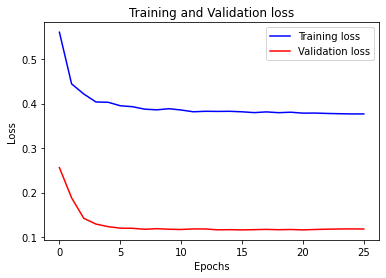

In [11]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
visualize_loss(history, "Training and Validation loss")

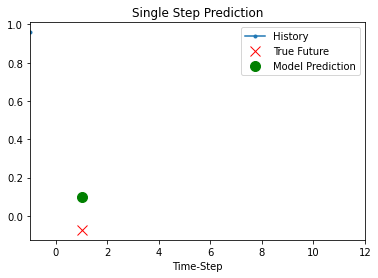

In [12]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_val.take(1):
    show_plot(
        [x[0][:, 0].numpy(), y[0].numpy(), model.predict(x)[0]],
        1,
        "Single Step Prediction",
    )

In [13]:
def denormalize(value):
    data_mean = mean[len(titles)-1]
    data_std = std[len(titles)-1]
    return value*data_std+data_mean

for x, y in dataset_val.take(10):
    predictionData = model.predict(x)
    denormalized_predictionData = denormalize(predictionData)[0]
    actualValue = y[0].numpy()
    print("predicted denormalized:", denormalized_predictionData)
    print("   actual denormalized:", denormalize(actualValue))
    print("             predicted:", predictionData[0])
    print("                actual:", actualValue)

# for x, y in datasetPredTest.take(1):
#     show_plot(
#         [x[0][:, 0].numpy(), y[0].numpy(), model.predict(x)[0]],
#         1,
#         "Single Step Prediction",
#     )

predicted denormalized: [[3552.2566]]
   actual denormalized: [3247.]
             predicted: [[0.09583914]]
                actual: [-0.07391816]
predicted denormalized: [[4670.245]]
   actual denormalized: [4037.]
             predicted: [[0.71756727]]
                actual: [0.36541127]
predicted denormalized: [[1951.2517]]
   actual denormalized: [2183.]
             predicted: [[-0.7945008]]
                actual: [-0.6656226]
predicted denormalized: [[3080.5005]]
   actual denormalized: [3197.]
             predicted: [[-0.16651066]]
                actual: [-0.10172382]
predicted denormalized: [[3149.4536]]
   actual denormalized: [3358.]
             predicted: [[-0.12816493]]
                actual: [-0.01218959]
predicted denormalized: [[2177.1558]]
   actual denormalized: [2244.]
             predicted: [[-0.6688726]]
                actual: [-0.6316997]
predicted denormalized: [[4969.902]]
   actual denormalized: [5346.]
             predicted: [[0.8842104]]
             

In [14]:
def normalize(data):
    return (data - mean) / std

predTest = pd.read_csv('TestData/testData1.csv',';')
mean = train[titles].values.mean(axis=0)
std = train[titles].values.std(axis=0)
featuresPredTest = predTest[titles]
predTestRange = int(featuresPredTest.shape[0])
featuresPredTest = normalize(featuresPredTest.values)
featuresPredTest = pd.DataFrame(featuresPredTest)
x_predTest = featuresPredTest[[i for i in range(9)]].values
y_predTest = featuresPredTest.iloc[0:][[9]]

datasetPredTest = keras.preprocessing.timeseries_dataset_from_array(
    x_predTest,
    y_predTest,
    sequence_length=1,
    sampling_rate=1,
    batch_size=1
)

for x, y in datasetPredTest.take(10):
    predictionData = model.predict(x)
    denormalized_predictionData = denormalize(predictionData)
    print("predicted denormalized:", denormalized_predictionData)
    print("             predicted:", predictionData)
    print("                actual:", y[0].numpy())

KeyError: '[8] not in index'

In [ ]:
# for x,y in datasetPredTest.take(2):
#     print(x[0][0].numpy(
normalize(featuresPredTest.values)

In [ ]:
print(mean[9], std[9])

In [ ]:
x_train

In [ ]:
x_train.shape

In [ ]:
y_train

In [ ]:
y_train.shape

In [ ]:
mean

In [ ]:
std

In [ ]:
train[titles].values.mean(axis=0)

In [ ]:
test = [[[3.96250010e+00, 5.92916600e+07, 7.00000000e+00, 7.00000000e+00, 4.53000021e+00, 1.08999996e+01, 1.99000000e+02, 2.00000000e+01, 4.00000000e+00, 0.00000000e+00]]]

In [ ]:
test

In [ ]:
(test-train[titles].values.mean(axis=0))/train[titles].values.std(axis=0)

In [ ]:
train[titles].values.mean(axis=0)

In [ ]:
train[titles].values.std(axis=0)